# Tracking low clouds in large-eddy simulations 

The dataset we are using is from [Cloud Botany](https://howto.eurec4a.eu/botany_dales.html).

Cloud Botany is a library of idealised large-eddy simulations forced by and initialised with combinations of simplified vertical profiles. Each profile is parameterised by variables which aim to make the ensemble span a range of conditions corresponding to the variability observed over the EUREC4A region during the boreal winter of 2019/2020. 

*This notebook was created by: William K. Jones, Milind Sharma, and Julia Kukulies*

In [148]:
from intake import open_catalog
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [149]:
# Import tobac itself
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.5.5


In [3]:
# Open EUREC4A catalogue to access data
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

In [152]:
# Open the cloud botany LES catalogue
cloud_botany = cat.simulations.DALES.botany
cloud_botany

botany:
  args:
    path: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES/botany.yaml
  description: Cloud botany LES ensemble
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES


In [160]:
# Load 2D cloud fields into an xarray dataset
ds = cloud_botany.dx100m.nx1536["2D"].to_dask()
ds

<xarray.Dataset> Size: 8TB
Dimensions:    (member: 103, time: 720, yt: 1536, xt: 1536)
Coordinates:
  * member     (member) int32 412B 1 2 3 4 5 6 7 8 ... 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 6kB 2020-02-01T00:05:00 ... 2020-02-03T1...
  * xt         (xt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
  * yt         (yt) float64 12kB 50.0 150.0 250.0 ... 1.534e+05 1.536e+05
Data variables:
    capemax    (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cinmax     (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    cldtop     (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hinvsrf    (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    hmix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    lwp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    rwp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    surfprec   (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    thetavmix  (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    twp        (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    umix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
    vmix       (member, time, yt, xt) float32 700GB dask.array<chunksize=(1, 32, 256, 256), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

### Select atmospheric variable to track on 

We choose the **liquid water path (LWP)** in kg m$^{-2}$ to track the evolution of shallow convection. 

In [153]:
# Select a shorter time period (here: 4 hours) and ensemble member and load the data into memory 
lwp_selected = ds.lwp.sel(member= 42,time=slice(datetime(2020,2,2,10), datetime(2020,2,2,14))).compute()

### Look at input data 

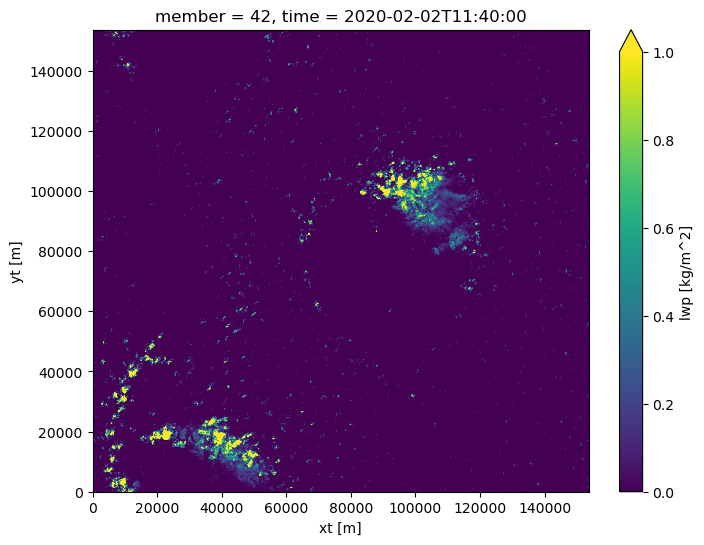

In [165]:
# choose a timestep
tt = 20 

plt.figure(figsize=(8,6))
lwp_selected[tt].plot(vmax = 1)
plt.show()

### Plot histogram of LWP values with chosen thresholds

We choose the thresholds 1 kg m$^{-2}$, 2 kg m$^{-2}$ and 5 kg m$^{-2}$ to identify cloud features in the simulations. 

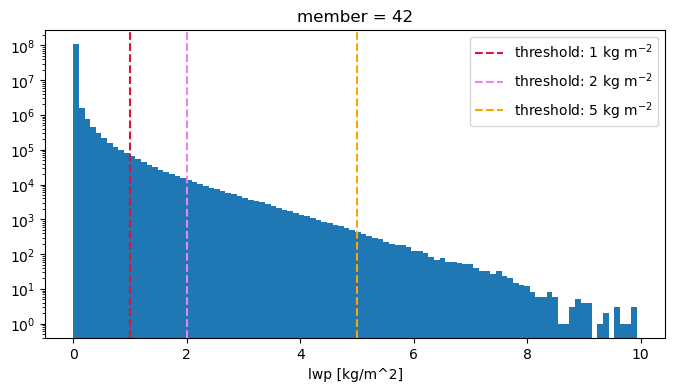

In [173]:
plt.figure(figsize= (8,4))
lwp_selected.plot(bins=100)
plt.axvline(x= 1 , color="crimson", linestyle="--", label = 'threshold: 1 kg m$^{-2}$')
plt.axvline(x= 2 , color="violet", linestyle="--", label = 'threshold: 2 kg m$^{-2}$')
plt.axvline(x= 5 , color="orange", linestyle="--", label = 'threshold: 5 kg m$^{-2}$')
plt.legend()
plt.yscale("log")

## Feature detection

! Note that the simulations we are looking at have periodic boundary conditions, so we use the **PBC_flag= 'both'** option to be able to detect and track features across the boundaries. 

In [42]:
# Dictionary containing keyword options (could also be directly given to the function)
dxy, dt = 100, 300
parameters_features={}
parameters_features['threshold']=[1, 2, 5] #kg/m^2
parameters_features['n_min_threshold']= 20
parameters_features['PBC_flag'] ="both"

In [43]:
Features = tobac.feature_detection_multithreshold(lwp_selected, **parameters_features)

In [144]:
Features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member
0,0,7,85.734378,1114.734362,64,1,1,2020-02-02 10:00:00,2020-02-02 10:00:00,8623.437775,111523.436245,111523.436245
1,0,9,92.918039,1168.967222,61,1,2,2020-02-02 10:00:00,2020-02-02 10:00:00,9341.803914,116946.722180,116946.722180
2,0,10,94.566676,1121.611270,90,1,3,2020-02-02 10:00:00,2020-02-02 10:00:00,9506.667605,112211.127021,112211.127021
3,0,14,108.615384,1127.269230,26,1,4,2020-02-02 10:00:00,2020-02-02 10:00:00,10911.538417,112776.922965,112776.922965
4,0,19,113.772727,913.045455,22,1,5,2020-02-02 10:00:00,2020-02-02 10:00:00,11427.272664,91354.545530,91354.545530


### Look at detected features in a specific time step

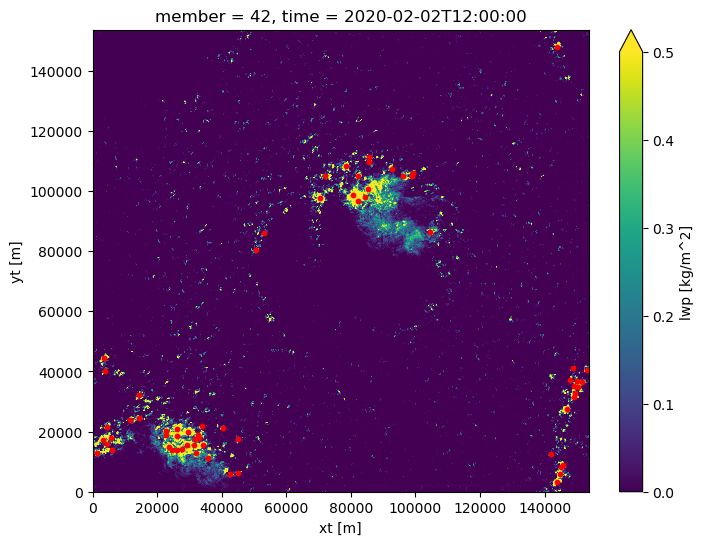

In [175]:
tt = 24

plt.figure(figsize=(8,6))
lwp_selected[24].plot(vmax=0.5)
plt.scatter(Features[Features.frame==tt].xt, Features[Features.frame==tt].yt, c="red", s = 10)
plt.show()

## Tracking of detected cloud features

In [176]:
Tracks = tobac.linking_trackpy(
    Features, None, dt=300, dxy=100, v_max=10, method_linking="predict", 
    adaptive_stop=0.2, 
    adaptive_step=0.95, 
    stubs=4,
    # subnetwork_size=100,
    min_h1=0,
    max_h1=1536,
    min_h2=0,
    max_h2=1536,
    PBC_flag='both')

Frame 48: 42 trajectories present.


In [184]:
# remove cells that are not tracked 
Tracks= Tracks[Tracks.cell > 0]
Tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,cell,time_cell
4,0,19,113.772727,913.045455,22,1,5,2020-02-02 10:00:00,2020-02-02 10:00:00,11427.272664,91354.545530,91354.545530,5,0 days
11,0,39,163.394724,853.131573,38,1,12,2020-02-02 10:00:00,2020-02-02 10:00:00,16389.472389,85363.157280,85363.157280,12,0 days
12,0,41,166.478888,960.380290,71,1,13,2020-02-02 10:00:00,2020-02-02 10:00:00,16697.888776,96088.028990,96088.028990,13,0 days
44,0,154,897.999995,1443.076923,26,1,45,2020-02-02 10:00:00,2020-02-02 10:00:00,89849.999485,144357.692321,144357.692321,45,0 days
51,0,187,1009.777776,118.111100,27,1,52,2020-02-02 10:00:00,2020-02-02 10:00:00,101027.777639,11861.109995,11861.109995,52,0 days


### Look at track

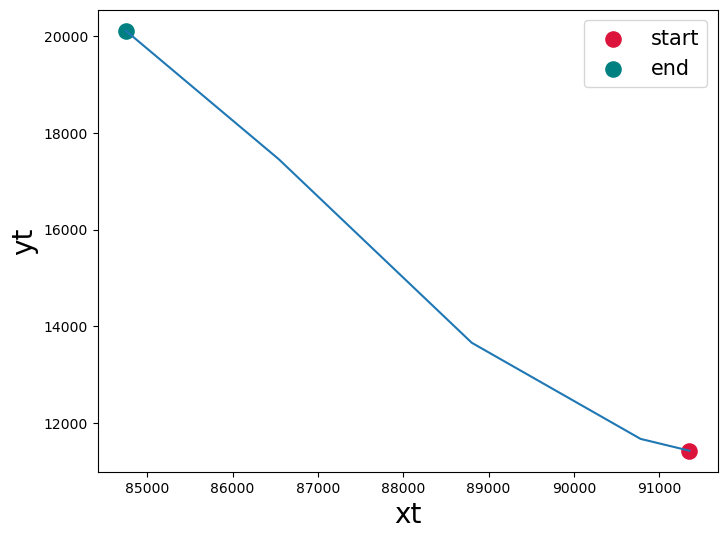

In [189]:
plt.figure(figsize=(8,6))
plt.plot(Tracks[Tracks.cell==cell].xt, Tracks[Tracks.cell==cell].yt)
plt.scatter(Tracks[Tracks.cell==cell].xt.values[0], Tracks[Tracks.cell==cell].yt.values[0], label = 'start', s = 120, c = 'crimson')
plt.scatter(Tracks[Tracks.cell==cell].xt.values[-1], Tracks[Tracks.cell==cell].yt.values[-1], label = 'end', s = 120 , c = 'teal')
plt.legend(loc = 'upper right', fontsize = 15 )
plt.xlabel('xt', fontsize = 20)
plt.ylabel('yt', fontsize = 20 )
plt.show()

### Where in the domain do we find this track? 

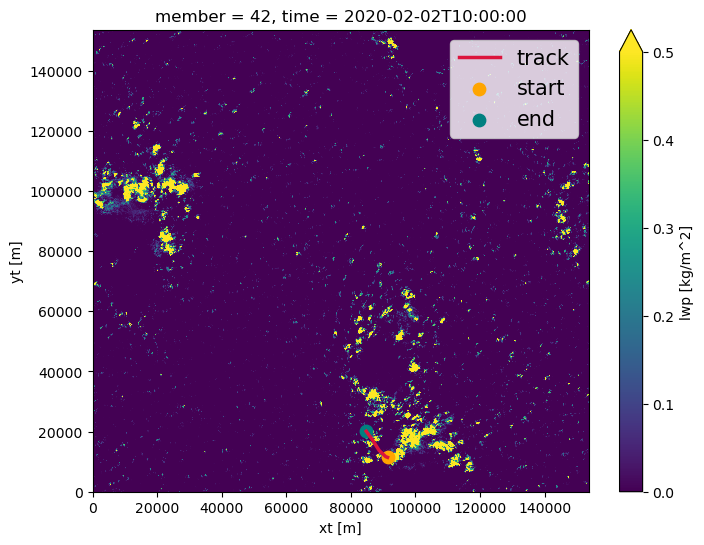

In [196]:
# select cell 
cell = 5 
frame = Tracks[Tracks.cell == cell].frame.values[0]

plt.figure(figsize=(8,6))
# plot the data for the first timeframe of cell 
lwp_selected[frame].plot(vmax=0.5)
plt.plot(Tracks[Tracks.cell==cell].xt, Tracks[Tracks.cell==cell].yt, color = 'crimson', linewidth = 2.5, label = 'track')
plt.scatter(Tracks[Tracks.cell==cell].xt.values[0], Tracks[Tracks.cell==cell].yt.values[0], label = 'start', s = 80, c = 'orange')
plt.scatter(Tracks[Tracks.cell==cell].xt.values[-1], Tracks[Tracks.cell==cell].yt.values[-1], label = 'end', s = 80 , c = 'teal')
plt.legend(loc = 'upper right', fontsize = 15 )
plt.show()

## Segmentation 

In [198]:
# Set parameters for segmentation 

parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 0.5
parameters_segmentation['PBC_flag']="both"

# get the LWP summed over all segmented grid cells that belong to a feature 
statistic = {'lwp_sum': np.sum}

In [90]:
mask, segmented_features = tobac.segmentation_2D(Tracks, lwp_selected, dxy = dxy, **parameters_segmentation)

### Look at the mask output 

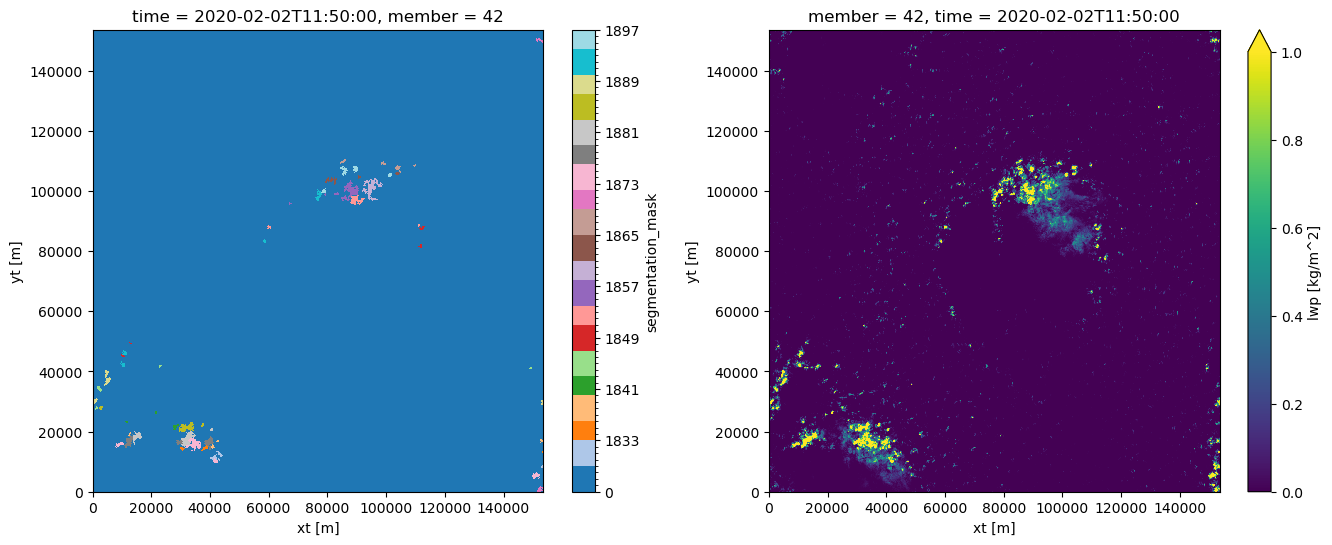

In [221]:
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.figure(figsize= (16,6))

# choose a timestep 
tt = 22

# plot mask 
labels = np.unique(mask[tt])
colors = plt.cm.tab20(np.linspace(0, 1, labels.size))
cmap = ListedColormap(colors)
norm = BoundaryNorm(labels, labels.size)
ax = plt.subplot(1,2,1)
m = mask[tt].plot(ax = ax, cmap = cmap, norm = norm )

# plot field 
ax = plt.subplot(1,2,2)
lwp_selected[tt].plot(ax = ax, vmax = 1 )

plt.show()

## Lifecycle analysis 

Let's have a look at the lifecycle of the clouds by analyzing their **evolution of LWP** during the tracking. 

For this, we: 

- first pick all cells that persist longer than 30 minutes
- normalize each lifecycle on a scale between 0 and 1 so that the lifetimes are comparable
- interpolate the area-integrated LWP (that we got from passing the *statistic* parameters in the segmentation step) onto the normalized lifetimes

**The output of this analysis will be a lifecycle composite showing the mean evolution of LWP over all tracked cloud cells.**

#### Filter out long-lived cells 

In [222]:
# find the maximum for each unique cell 
max_times = segmented_features.groupby('cell').time_cell.max()
# subset times by selecting only cells that have a maximum time longer than 30 min
long_times= max_times[max_times >= np.timedelta64(30, "m")]
# use a boolean mask to subset the original dataframe 
matched_cells = np.isin(segmented_features.cell, long_times.index)
long_lived_cells = segmented_features[matched_cells]

#### Convert lifetimes into normalized lifetimes on a scale from 0 to 1 

In [225]:
from scipy.interpolate import interp1d

def get_normalized_lifecycle(cell, var = 'lwp_sum', bins = np.arange(0,1.05,0.05)):
    '''
    This function interpolates the values of a given variable 

    Parameters: 
        cell (pd.DataFrame): dataframe for selected unique cell 
        var (str): variable to interpolate 
        bins(np.array): bins on normalized lifetime scale that serve as coordinates for interpolation 

    Returns: 
        interpolated (np.array): array with the shape of the given bins containing the interpolated values 
    
    '''
    lifetime = cell.time.size
    time_percentage = np.linspace(0, 1, lifetime)
    interp_func = interp1d(time_percentage, cell[var] , kind = 'linear', fill_value = 'extrapolate')
    interpolated = interp_func(bins)
    return interpolated

In [138]:
# Loop through all individual cells and get their LWP evolution on the normalized lifetime dimension

# list to store the 
all_cells = []

for cell in long_lived_cells.cell.unique():
    # select unique cell 
    cell_df = long_lived_cells[long_lived_cells.cell == cell]
    # get the interpolated LWP values along the normalized time dimension
    interpolated_lwp = get_normalized_lifecycle(cell_df)
    all_cells.append(interpolated_lwp)

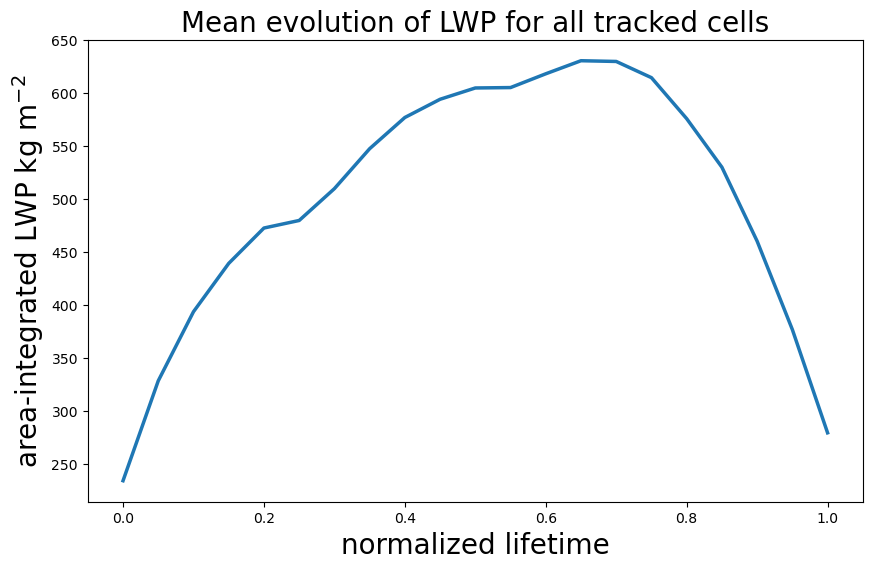

In [235]:
plt.figure(figsize= (10,6))


fs = 20 # fontsize 

plt.plot(lwp_composite, lw = 2.5)
plt.title('Mean evolution of LWP for all tracked cells', fontsize= fs )
plt.xticks(np.arange(0,lwp_composite.size)[::4], np.round(np.arange(0,1.05,0.05)[::4], decimals = 2))
plt.ylabel('area-integrated LWP kg m$^{-2}$', fontsize=  fs)
plt.xlabel('normalized lifetime', fontsize = fs )
plt.show()